# Regression 

In [24]:
import jax.numpy as np
import numpy as onp
import jax
import seaborn as sns
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import ADAMLL as ada
from ADAMLL.activations import relu, sigmoid, eye, tanh
print("jax backend {}".format(xla_bridge.get_backend().platform))

jax backend gpu


## Data

In [9]:
n = 32  # Number of rows
m = 32  # Number of columns
perlin_noise_map = ada.generate_perlin_noise(n, m, seed=9999, scale=0.06) + jax.random.normal(jax.random.PRNGKey(2024), (n, m)) * 0.07

def simplerFunction(x):
    return 0.2*x + 0.8*x**2 + 2*x**3


x shape: (1024, 2)
t shape: (1024, 1)


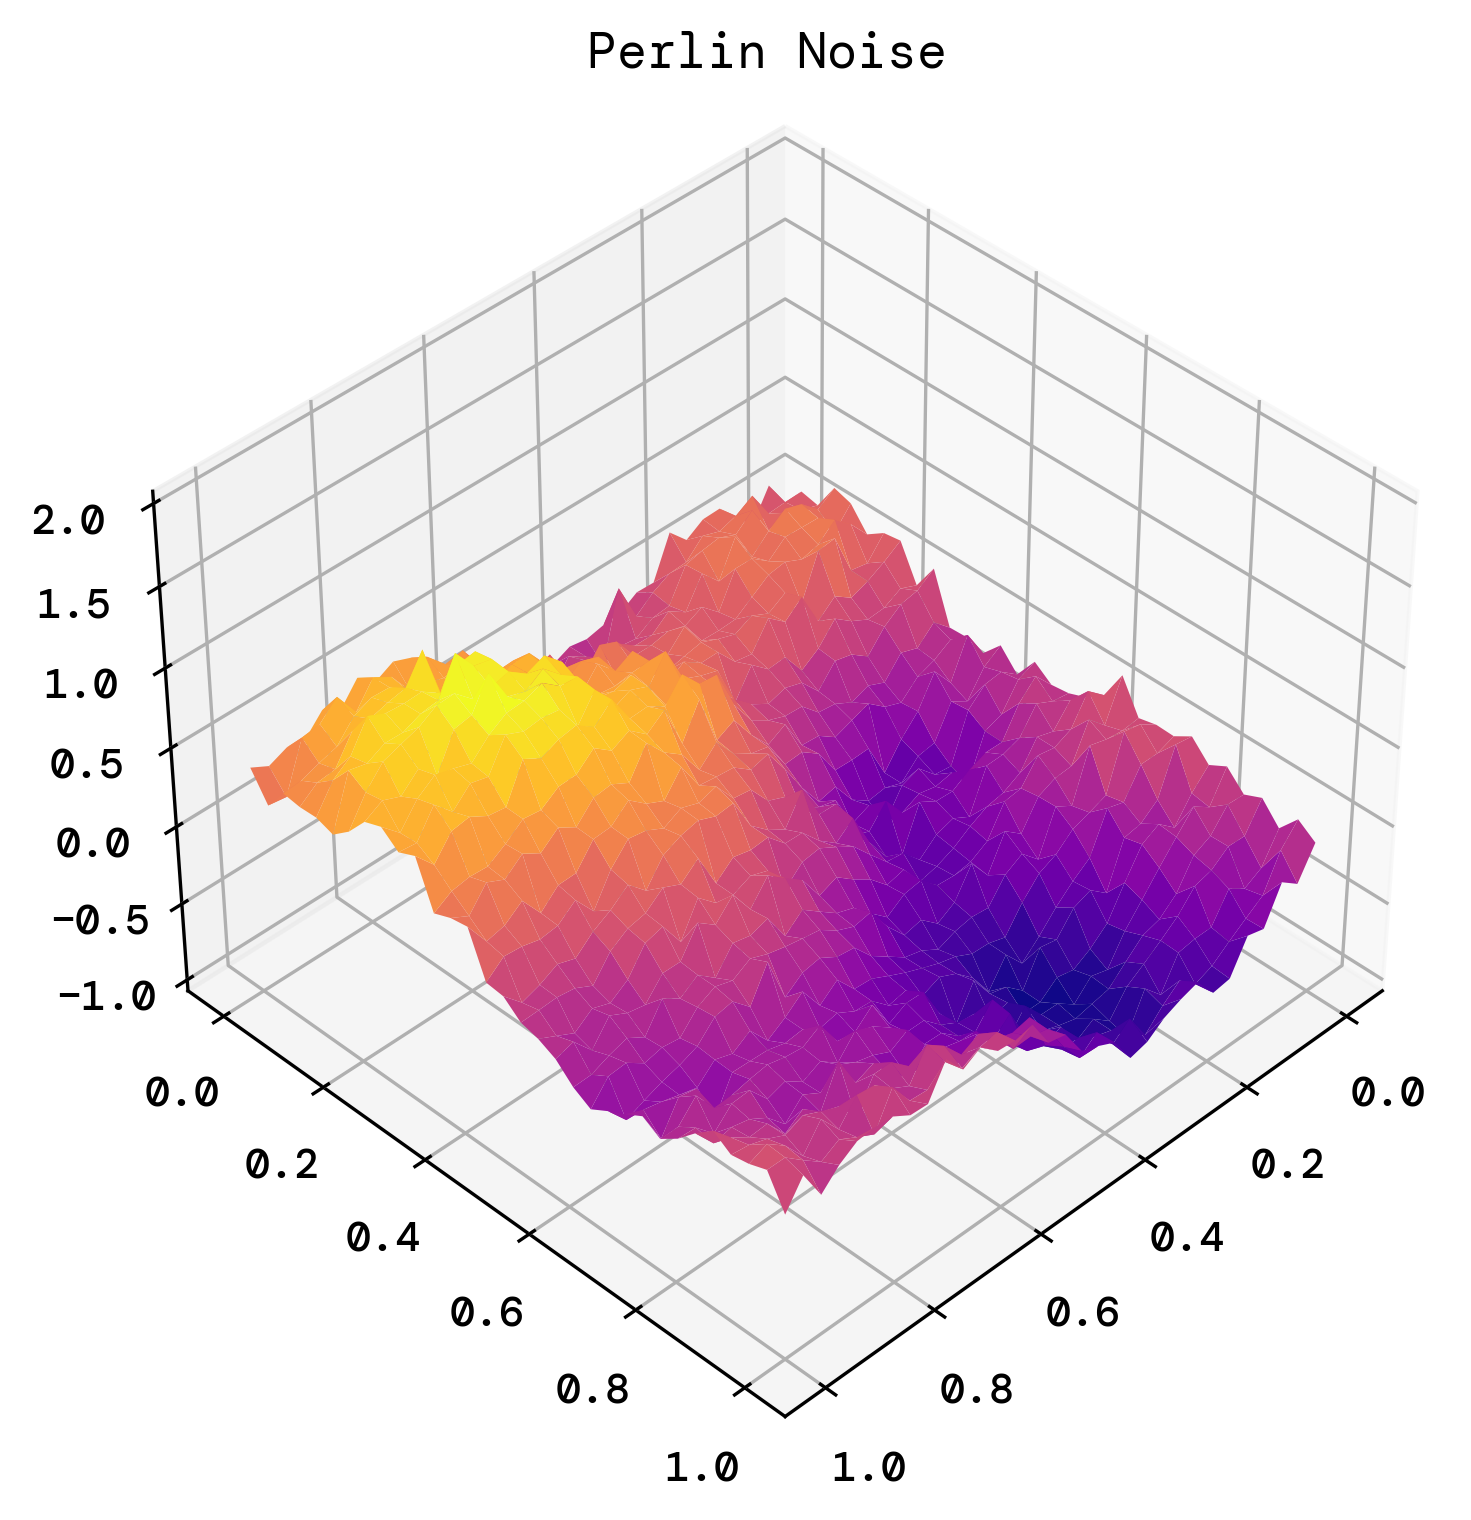

In [10]:
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, perlin_noise_map, cmap='plasma',
                       linewidth=0, antialiased=True)
# fig.colorbar(surf, shrink=0.5, aspect=5)
fig.tight_layout()
ax.set_title("Perlin Noise")
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)
plt.savefig("../runsAndFigures/perlinNoise.png",bbox_inches='tight')


x = np.vstack([X.ravel(), Y.ravel()]).T
y = perlin_noise_map.reshape(-1, 1)

# ax.scatter(x[:, 0], x[:, 1], y, c=y.ravel(), cmap='plasma')
print("x shape: {}".format(x.shape))
print("t shape: {}".format(y.shape))

## Preprocessing

In [11]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

## Automatic differentiation

Training stopped after 99 epochs                                      auto vs manual
auto {'b': Array([0.24602726], dtype=float32), 'w': Array([[ 0.4130881 ],
       [-0.94576377]], dtype=float32)}
manual {'b': Array([0.24602732], dtype=float32), 'w': Array([[ 0.4130881],
       [-0.9457639]], dtype=float32)}


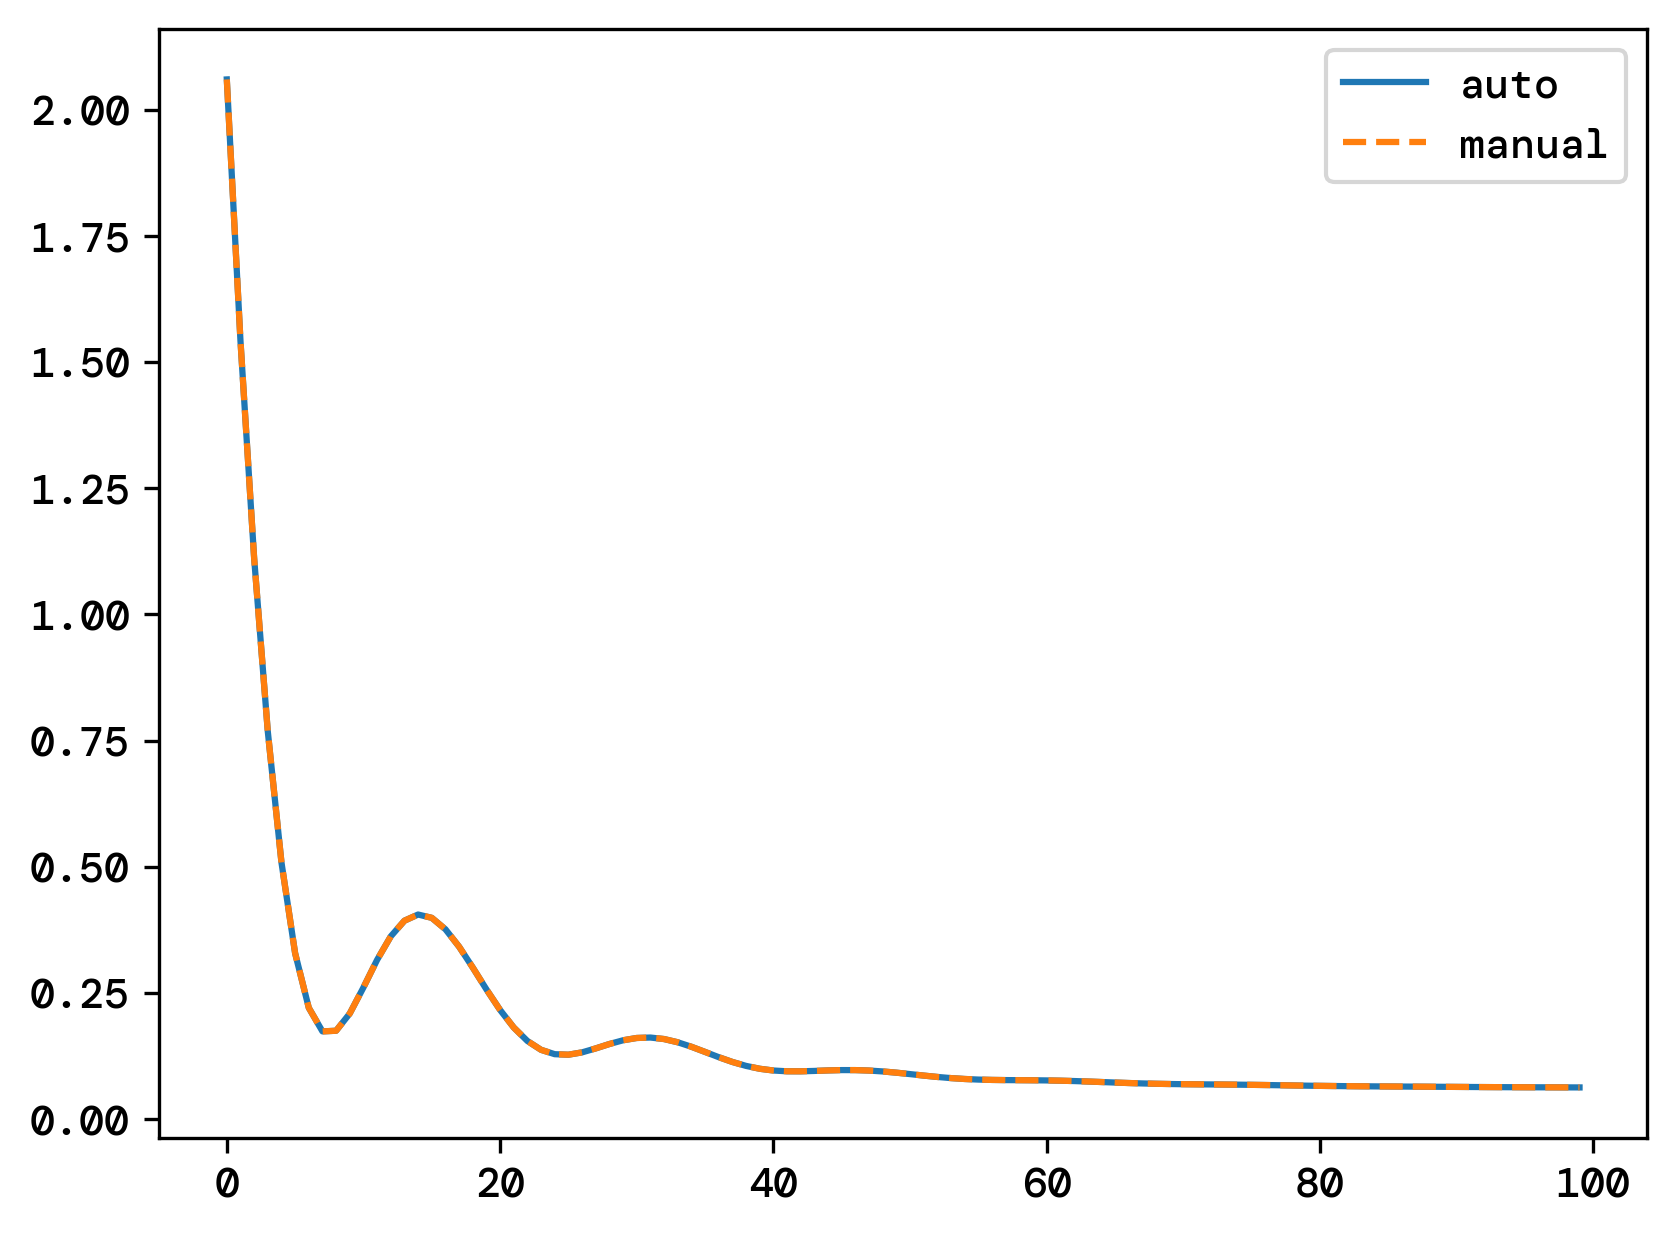

In [12]:
auto = ada.NN.Model([[1,eye]], eta=0.1, epochs=100 , alpha=0,optimizer="adam", loss=ada.MSE, metric=ada.MSE)
manual = ada.NN.Model([[1,eye]], eta=0.1, epochs=100 , backwards=ada.NN.backwards_no_hidden, alpha=0, optimizer="adam", metric=ada.MSE)

lossAuto, params_auto = auto.fit(X_train, y_train, X_test, y_test)
lossManual, params = manual.fit(X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(lossAuto,label="auto")
plt.plot(lossManual,"--", label="manual")
plt.legend()
print("auto vs manual")
print("auto",params_auto[0])
print("manual",params[0])

# Analysis

In [13]:
etas = [ 0.0001, 0.001, 0.01, 0.1  ]
epochs =200
eta = 0.1
tol = 0.001
epsilon = 1e-8
gammas = [0.0, 0.1, 0.5, 0.9]
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
alpha = 0.00001

kfold = KFold(n_splits=6)

def cross_val(X_train, y_train, model, kfold, batch_size=None):
    k = 0
    score = onp.zeros(kfold.n_splits)
    for train_ind, test_ind in kfold.split(X_train):
        loss, _ = model.fit(X_train[train_ind], y_train[train_ind], X_train[test_ind], y_train[test_ind], batch_size=batch_size)
        score[k] = loss[-1]
        k += 1
    return score.mean(), score.std()


poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)


## Learning rate and momentum

In [45]:
scores_lr_gamma = onp.zeros((len(etas), len(gammas)))
for i, e in enumerate(etas):
    for j, g in enumerate(gammas):
        model =  ada.NN.Model([[1,eye]], e, epochs, tol, "sgd", alpha, g, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE)
        mean , _ = cross_val(X_train_poly, y_train, model, kfold)
        scores_lr_gamma[i, j] = mean
    print(ada.progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))

Training stopped after 199 epochs                                     Progress: [-->                 ] 18%
Training stopped after 199 epochs                                     Progress: [------->            ] 43%
Training stopped after 199 epochs                                     Progress: [------------>       ] 68%
Training stopped after 199 epochs                                     

/home/brage/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Training stopped after 199 epochs                                     Progress: [----------------->  ] 93%


In this case havving momentum seems to be beneficial. We maxes out our testing range and found that 0.9 was the best value for momentum. momentum allows a higher learning rate

## Regularization

In [15]:
alphas = [0, 0.0001, 0.001, 0.01, 0.1]
scores_alpha = onp.zeros((len(alphas), 2) )
for i, a in enumerate(alphas):
    model =  ada.NN.Model([[1,eye]], eta, epochs, tol, "sgd", a, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold)
    scores_alpha[i] = [mean, var] 
    print(ada.progress_bar(i, len(alphas)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [--->                ] 20%
Training stopped after 199 epochs                                     Progress: [------->            ] 40%
Training stopped after 199 epochs                                     Progress: [----------->        ] 60%
Training stopped after 199 epochs                                     Progress: [--------------->    ] 80%


## Batch size

In [42]:
batch_sizes = [ 50, 100, 500 ]
score_batches = onp.zeros((len(batch_sizes), 2) )
for i, batch_size in enumerate(batch_sizes):
    model =  ada.NN.Model([[1,eye]], 0.01, epochs, tol, "sgd", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold, batch_size=batch_size)
    score_batches[i] = [mean, var]
    print(ada.progress_bar(i, len(batch_sizes)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [----->              ] 33%
Training stopped after 199 epochs                                     Progress: [------------>       ] 66%


## Optimizers

In [17]:
optimizer_names = ['adam', 'adagrad', 'rmsprop', 'sgd']
scores_optimizer = onp.zeros((len(optimizer_names), 2) )
for i, optimizer in enumerate(optimizer_names):
    model =  ada.NN.Model([[1,eye]], eta, epochs, tol, optimizer, a, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train_poly, y_train, model, kfold)
    scores_optimizer[i] = [mean, var]
    print(ada.progress_bar(i, len(optimizer_names)))


Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [-------------->     ] 75%


## Layers
important to remove the polynomial features when using a neural network

In [21]:
X_train_scaled = scaler.fit_transform(X_train)

n_layers = [1,2, 3, 4, 5]
n_nodes  = [2, 3, 5, 10]
scores_layers_nodes = onp.zeros((len(n_layers), len(n_nodes) ) )
for i, n_layer in enumerate(n_layers):
    for j, n_node in enumerate(n_nodes):
        model =  ada.NN.Model([[n_node,relu]]*n_layer + [[1,eye]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
        mean, var = cross_val(X_train_scaled, y_train, model, kfold)
        scores_layers_nodes[i, j] = mean
        print(ada.progress_bar(i*len(n_nodes) + j, len(n_layers)*len(n_nodes)))


Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [>                   ] 6%
Training stopped after 199 epochs                                     Progress: [->                  ] 12%
Training stopped after 199 epochs                                     Progress: [-->                 ] 18%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [----->              ] 31%
Training stopped after 199 epochs                                     Progress: [------>             ] 37%
Training stopped after 199 epochs                                     Progress: [------->            ] 43%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs      

## Activation functions

In [28]:
acitvs = [relu, sigmoid, tanh]
scores_activs = onp.zeros((len(acitvs), 2) )
for i, activ in enumerate(acitvs):
    model =  ada.NN.Model([[10,activ],[1,eye]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.MSE, metric=ada.MSE) 
    mean, var = cross_val(X_train, y_train, model, kfold)
    scores_activs[i] = [mean, var]
    print(ada.progress_bar(i, len(acitvs)))

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [----->              ] 33%
Training stopped after 199 epochs                                     Progress: [------------>       ] 66%


## Plot

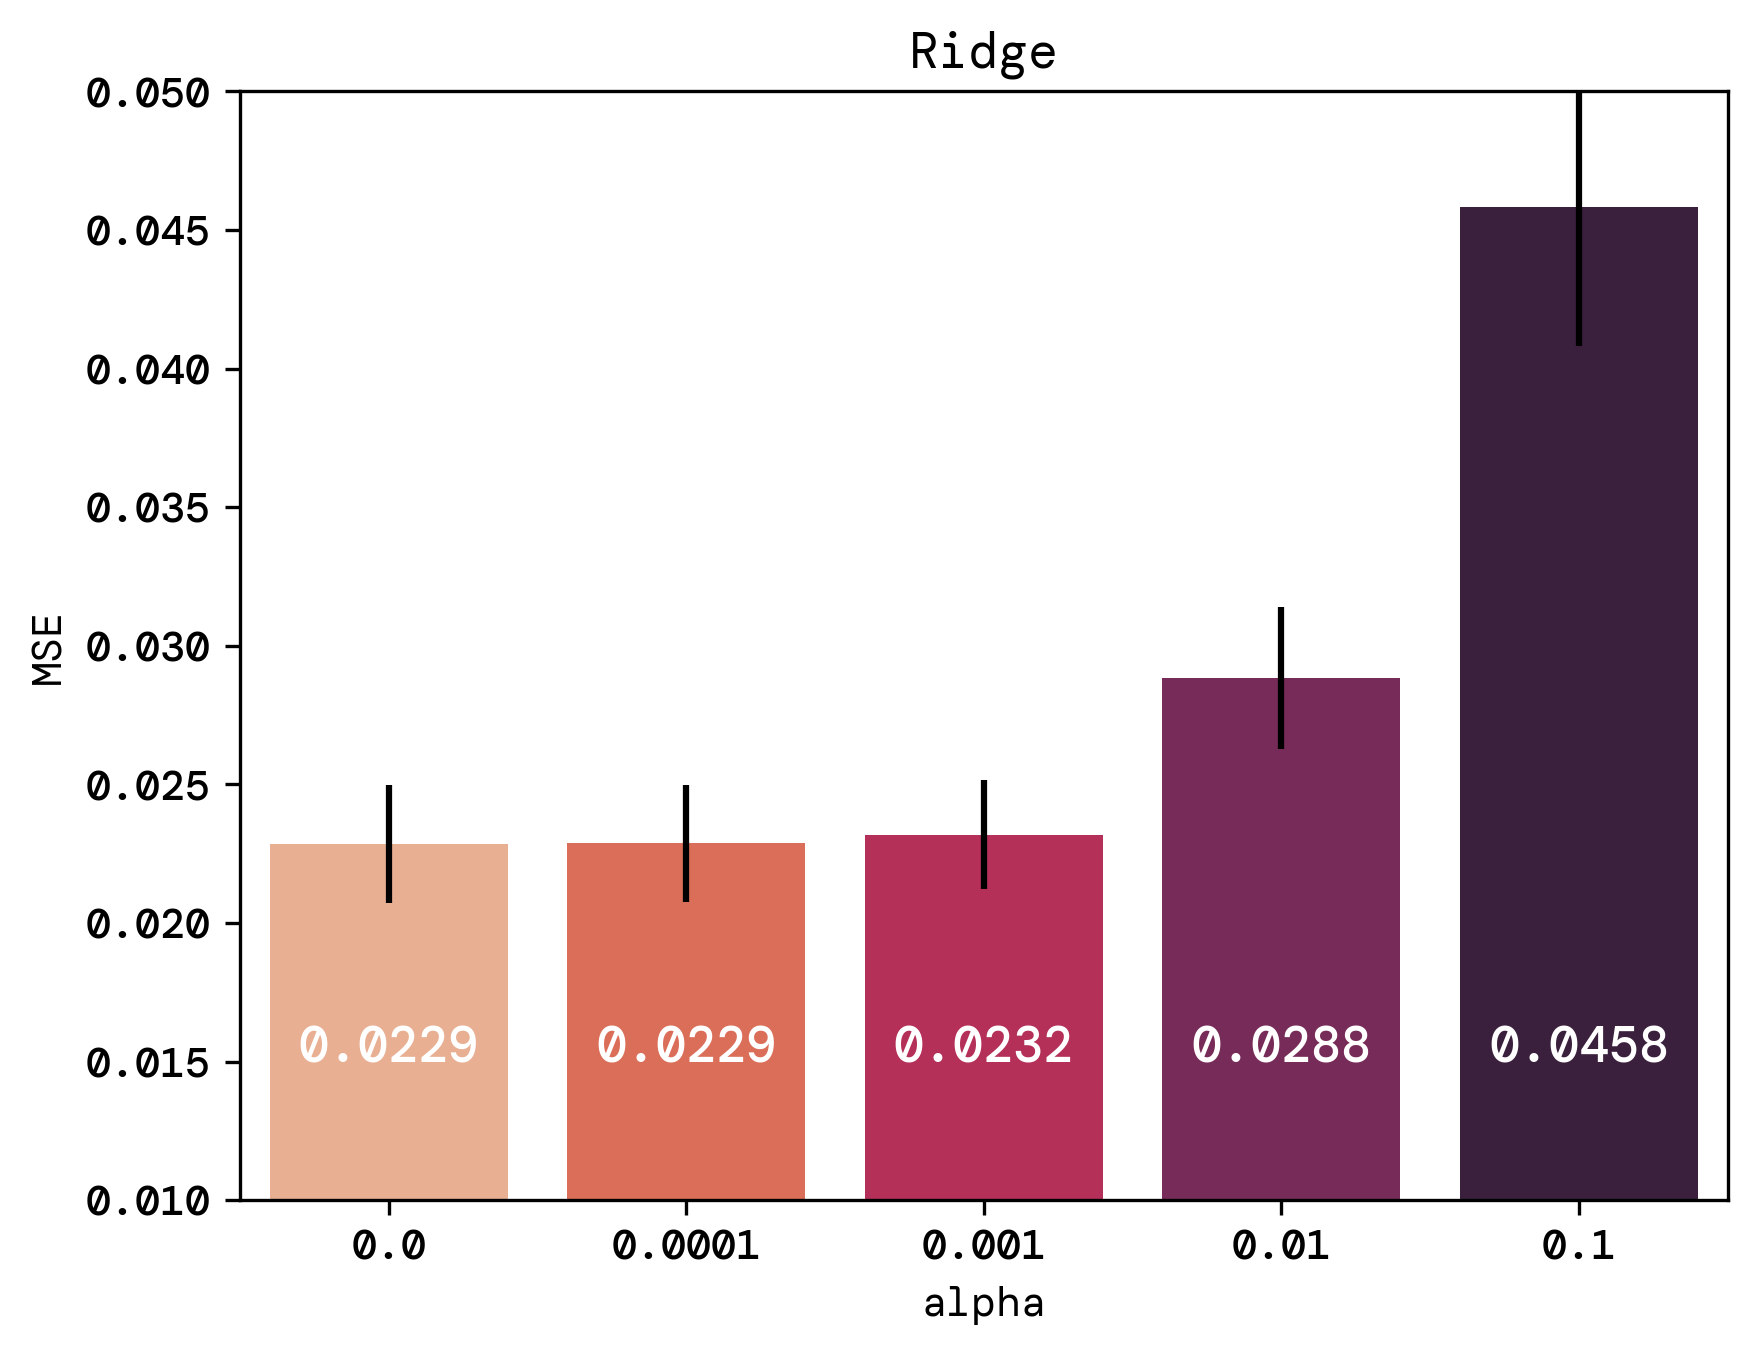

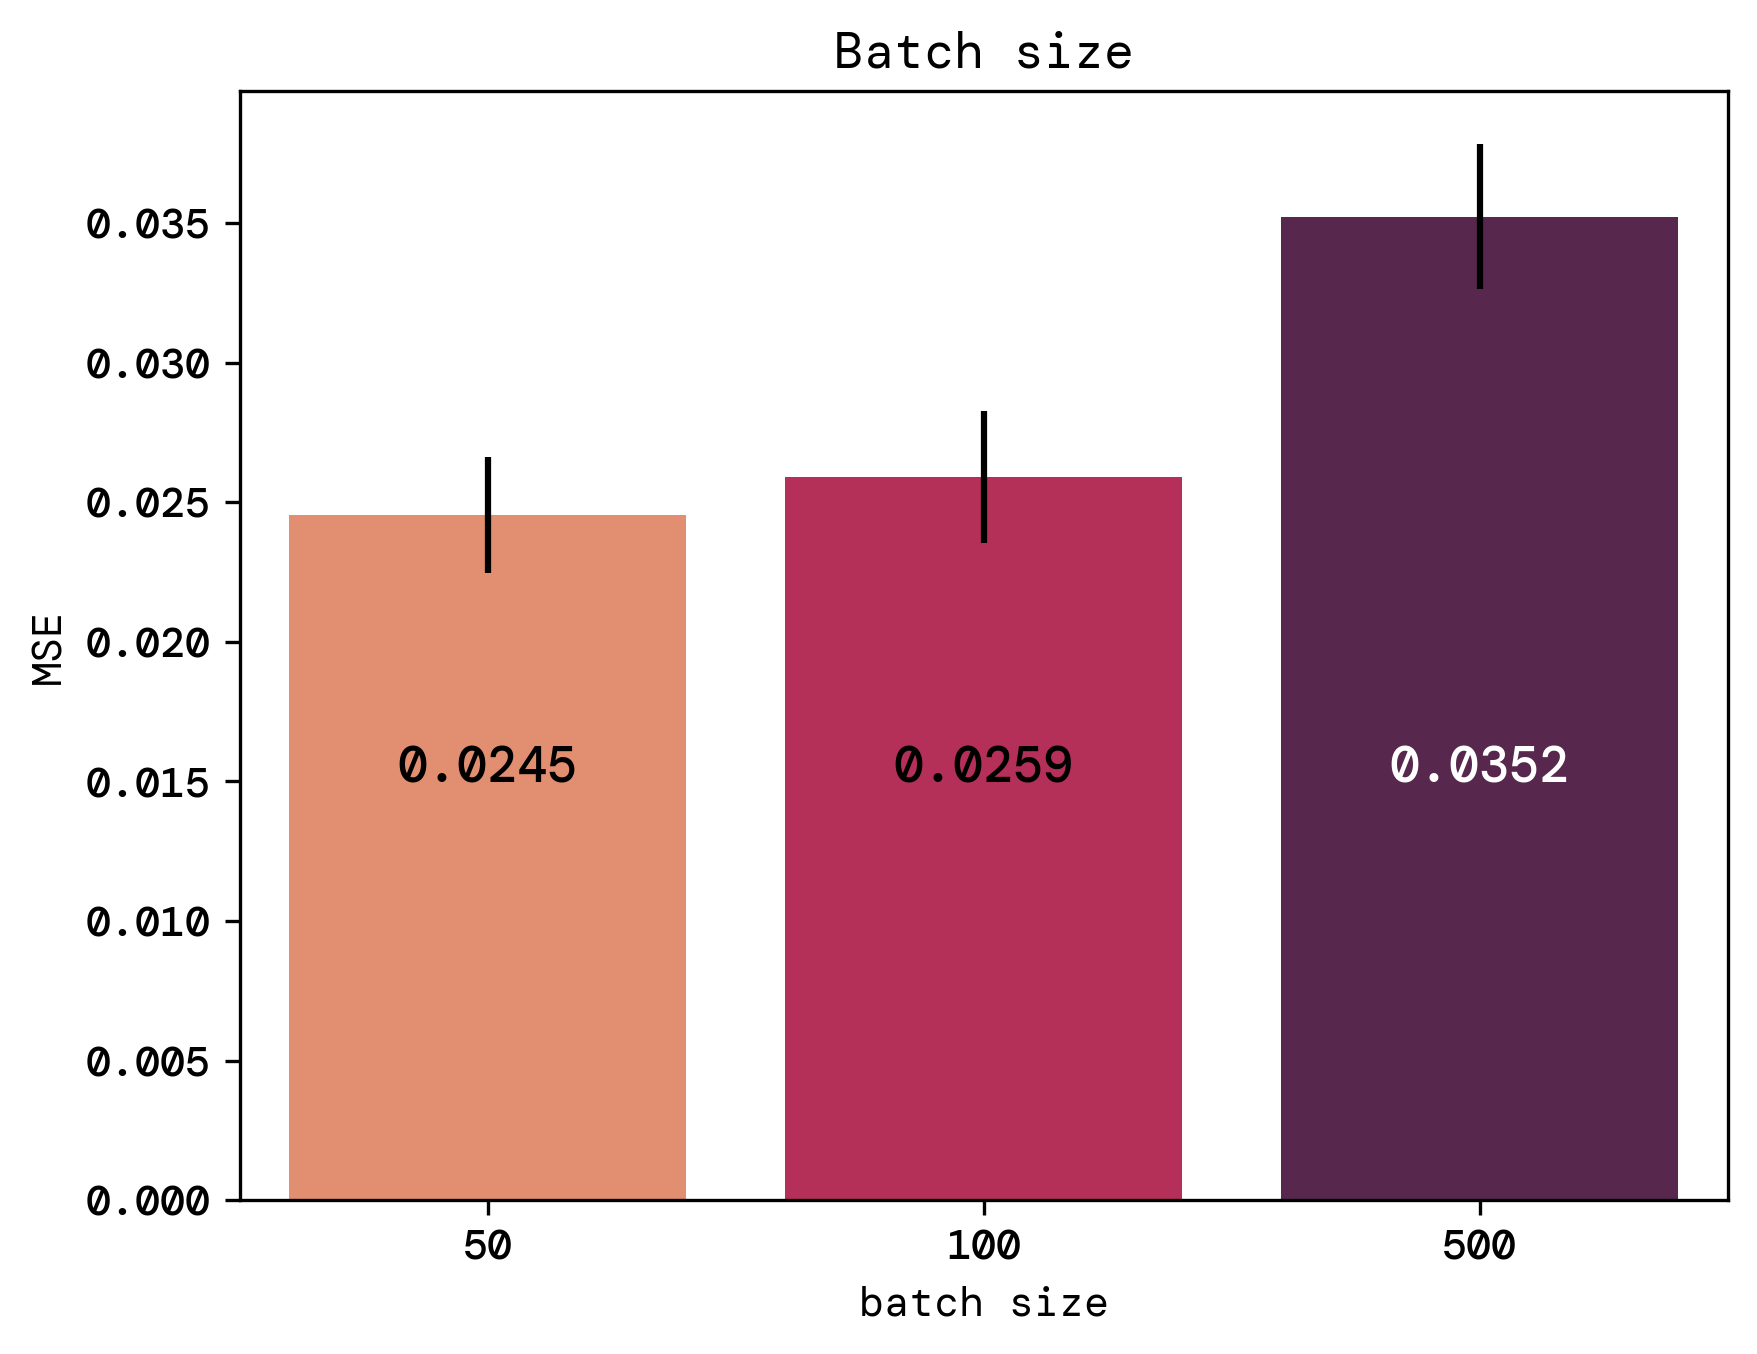

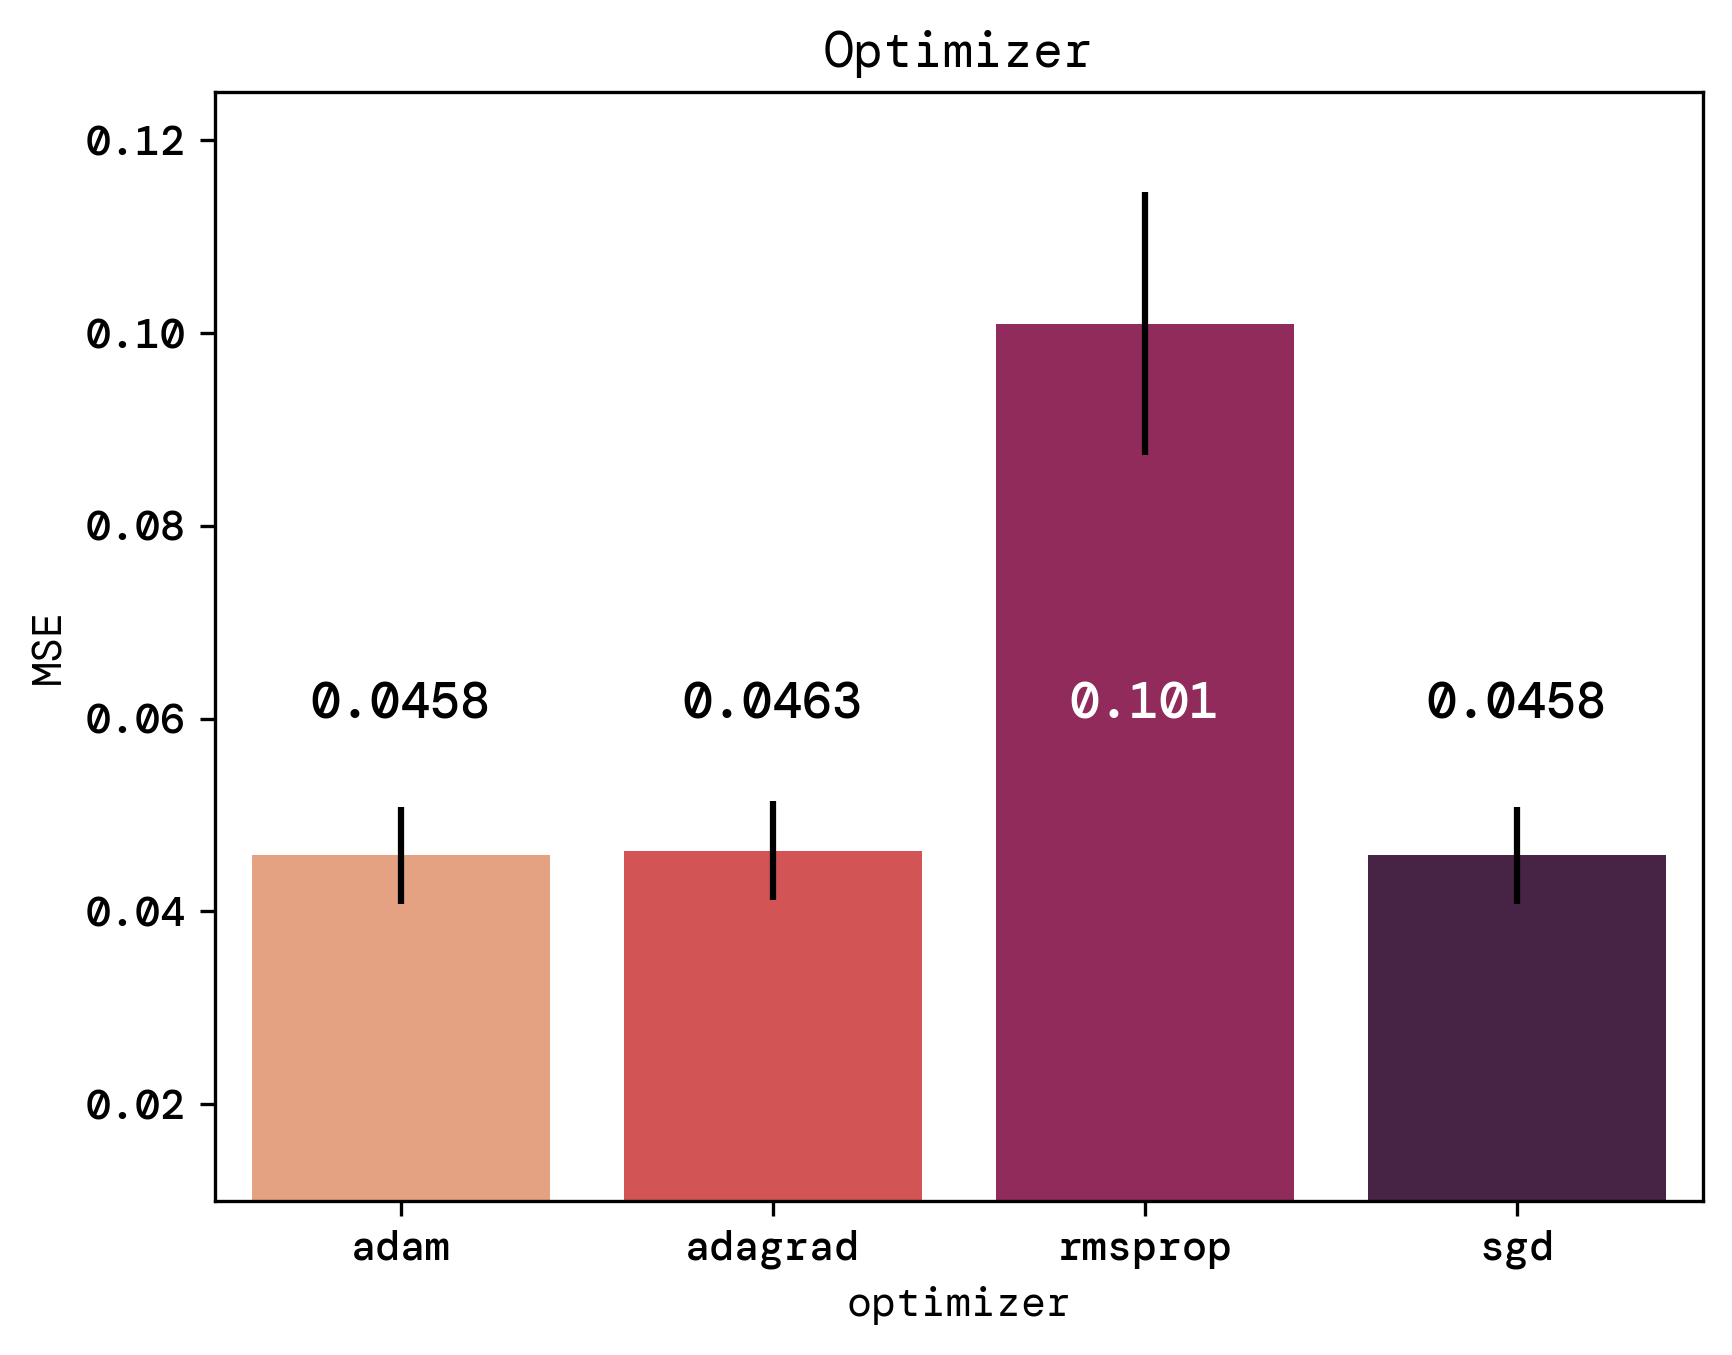

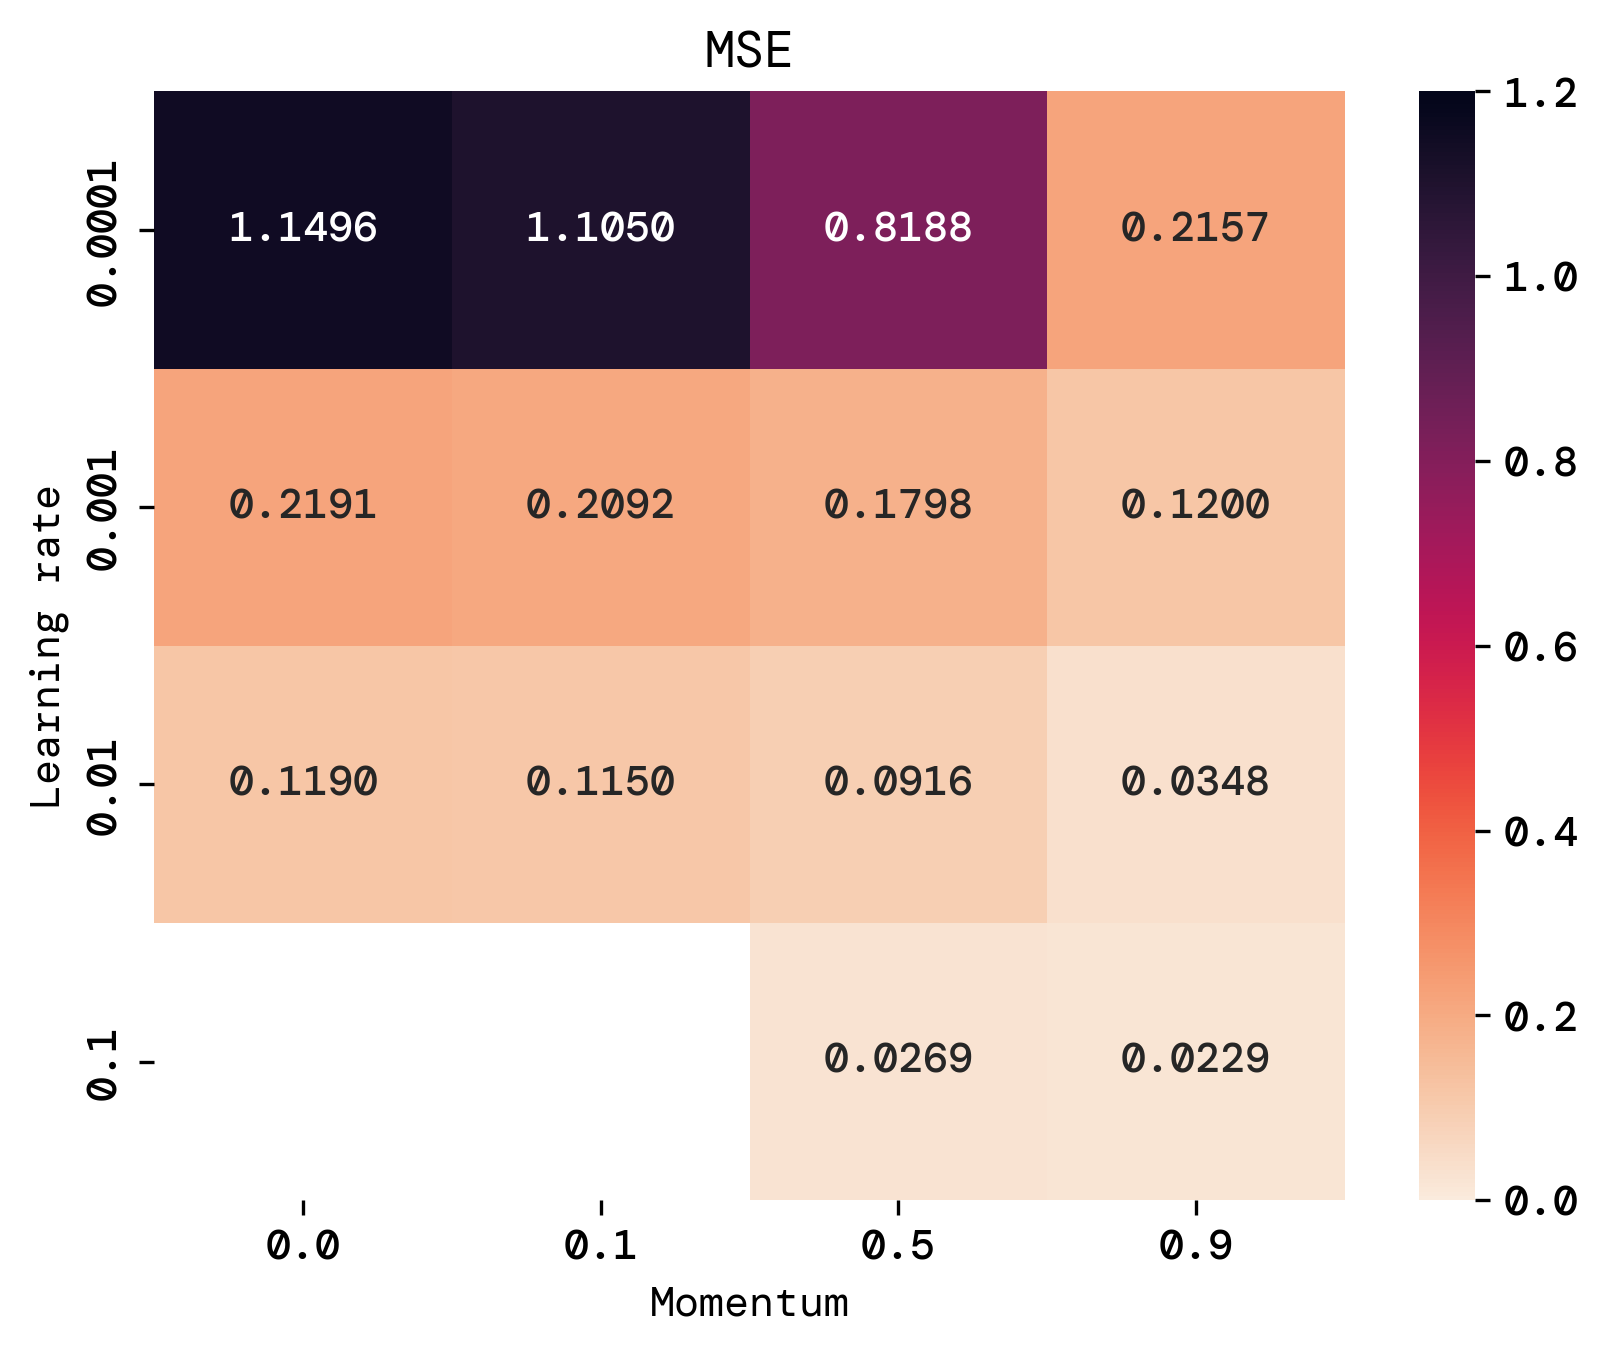

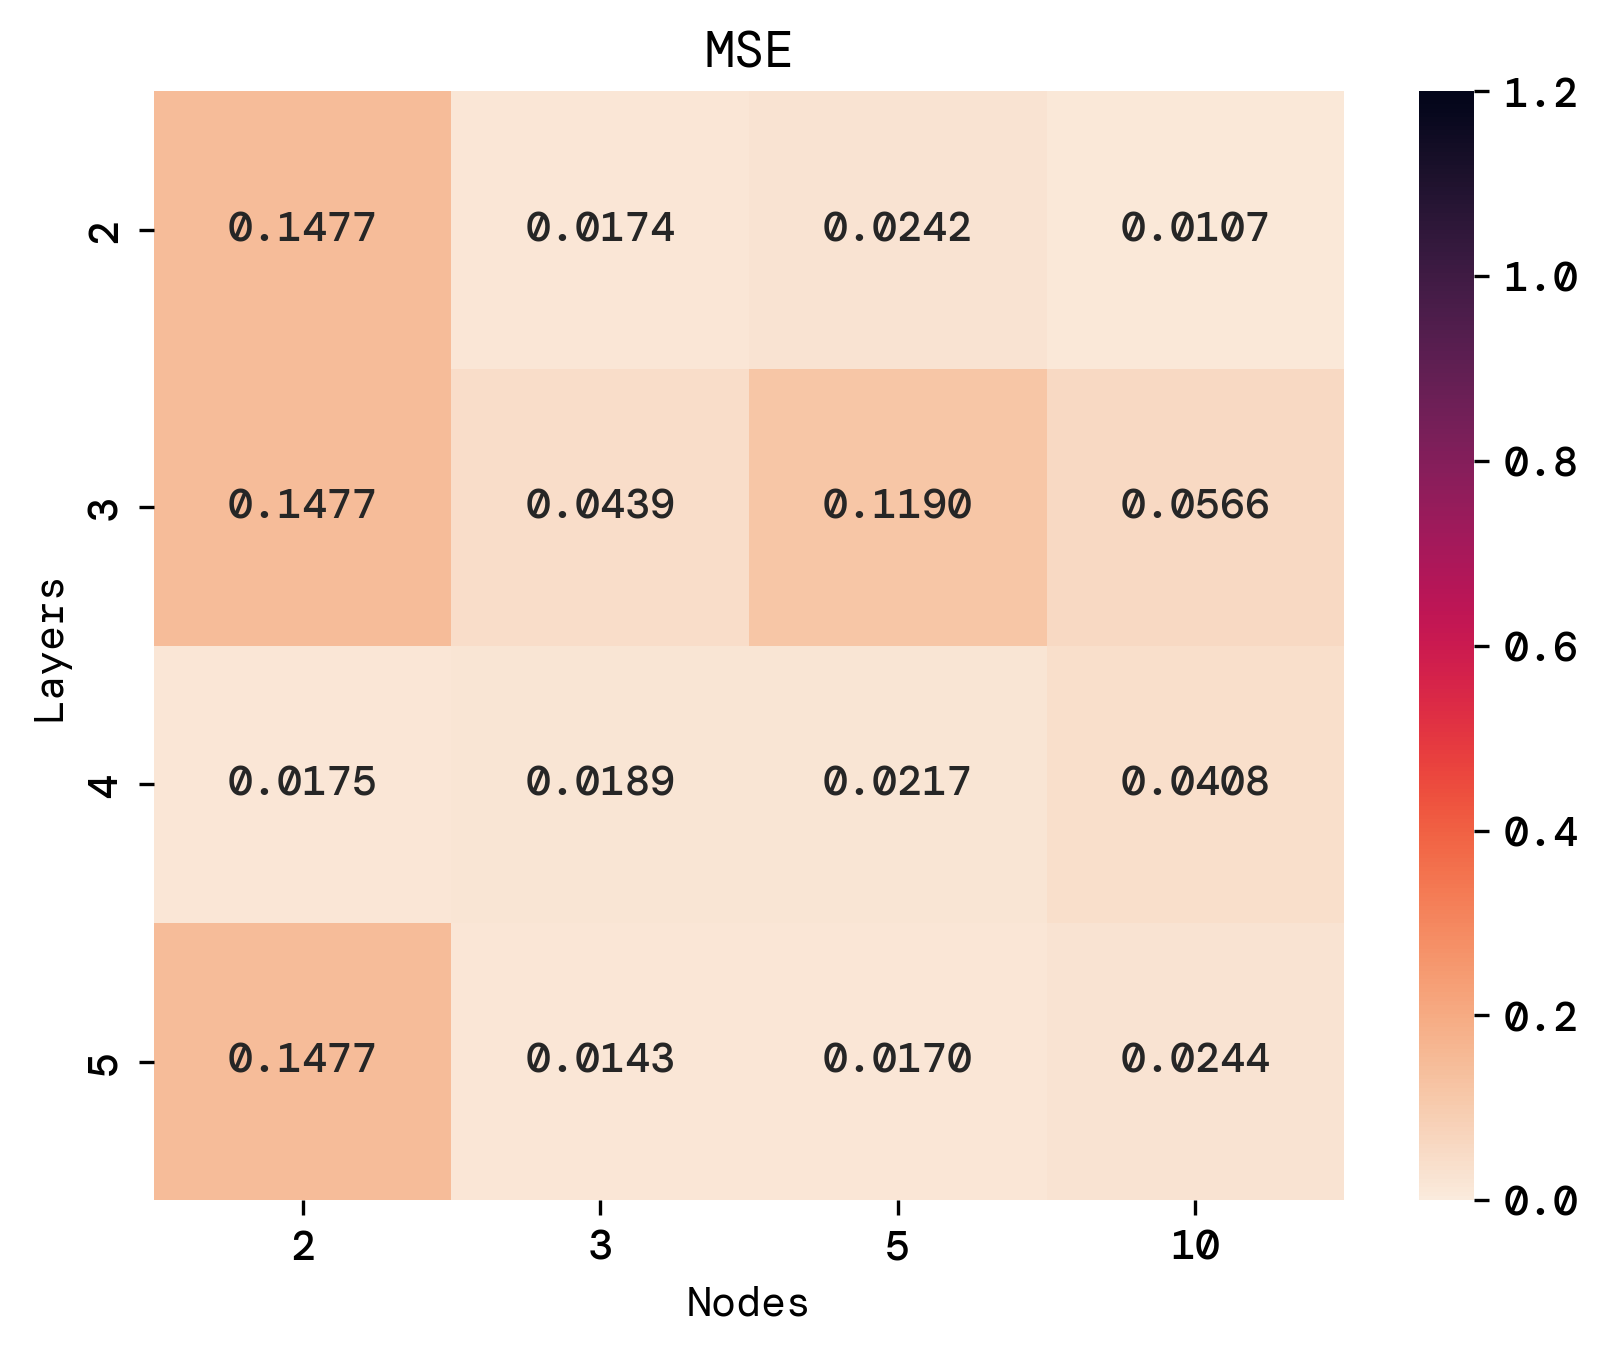

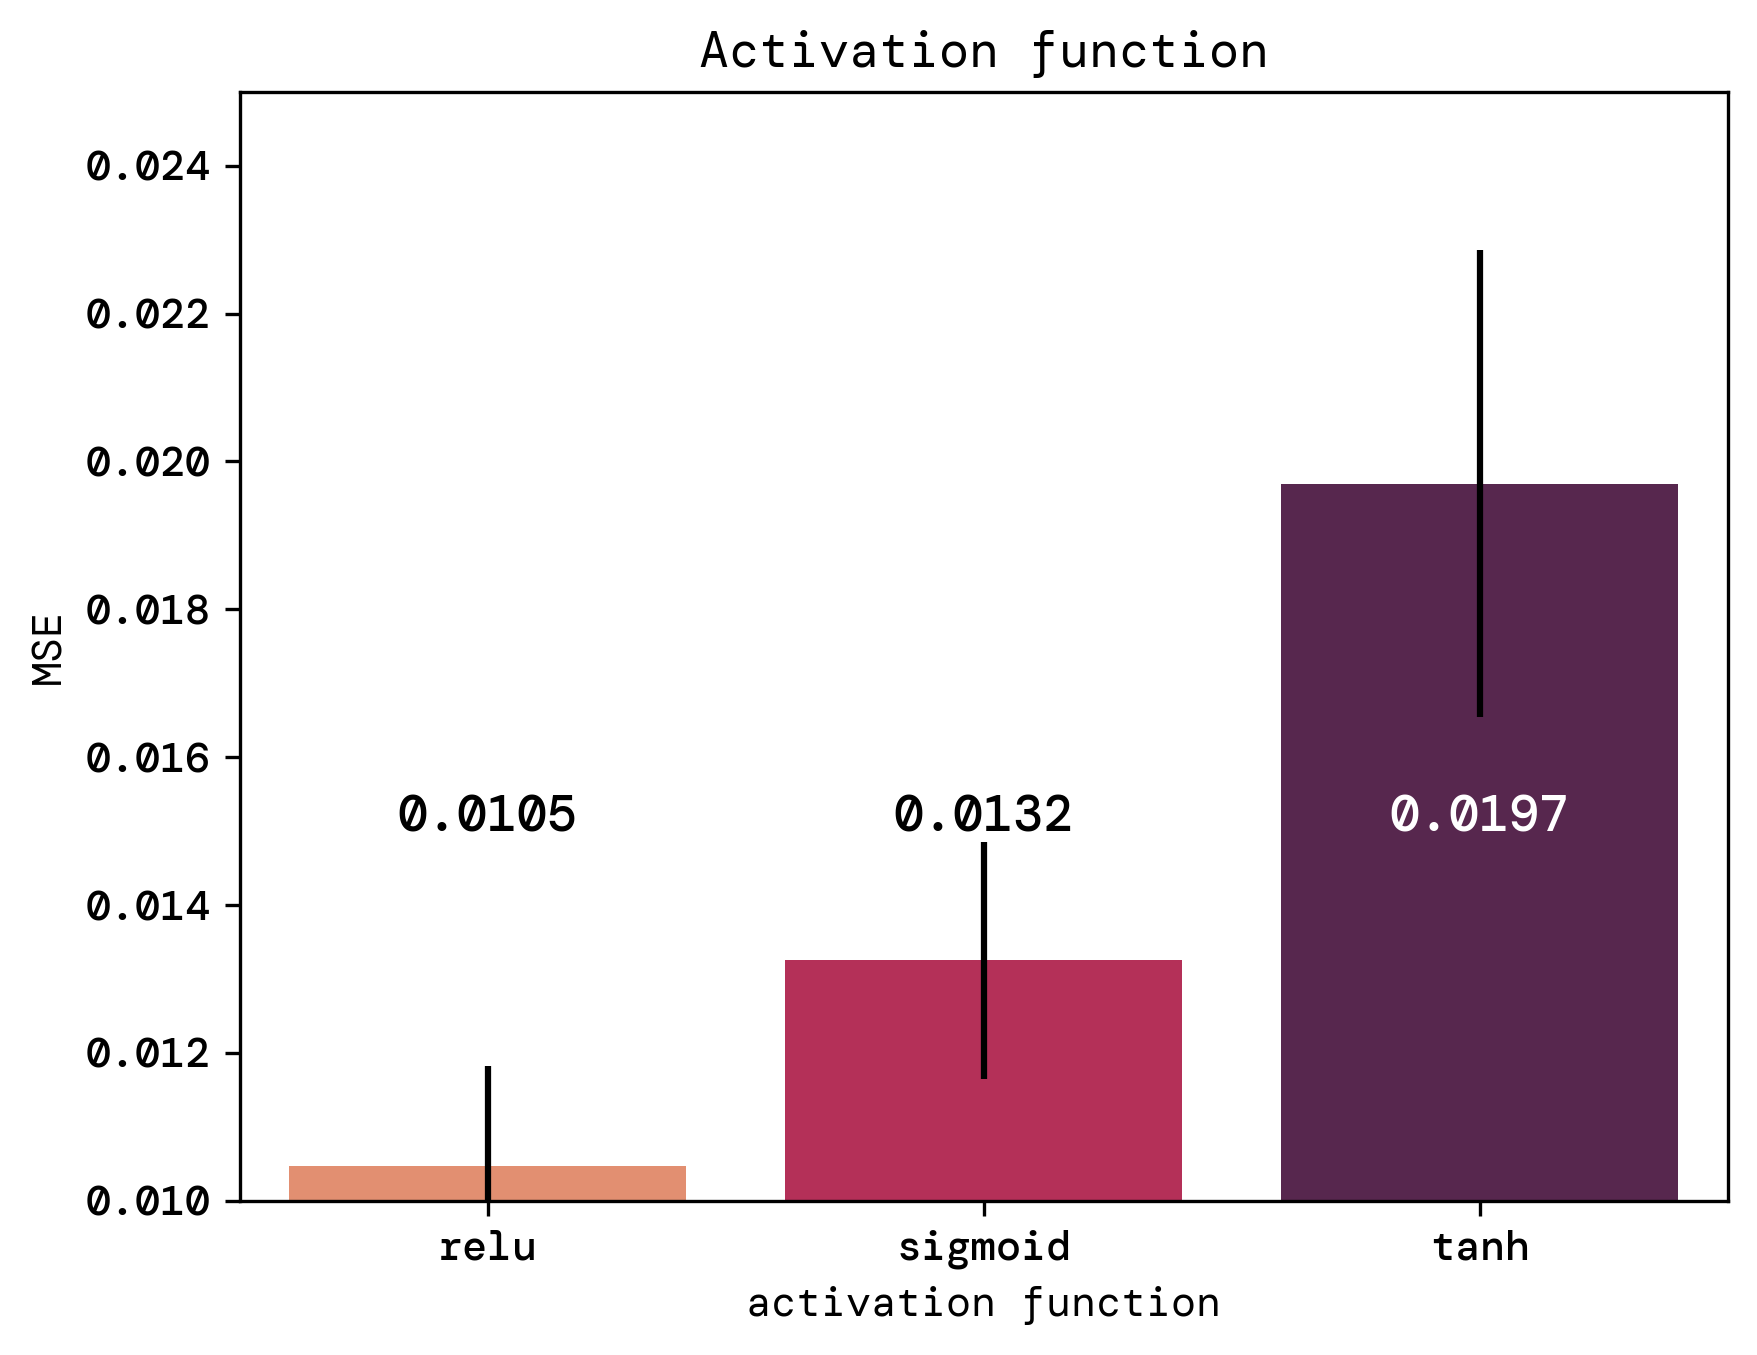

In [44]:

ax = sns.barplot(x=alphas, y=scores_alpha[:,0], palette="rocket_r", yerr=scores_alpha[:,1])
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("Ridge")
ax.set_ylim(0.01, 0.05)
ax.text(0, 0.015, f"{scores_alpha[0,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(1, 0.015, f"{scores_alpha[1,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(2, 0.015, f"{scores_alpha[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.015, f"{scores_alpha[3,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(4, 0.015, f"{scores_alpha[4,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_alpha.png",bbox_inches='tight')
plt.show()


plt.figure()
ax = sns.barplot(x=batch_sizes, y=score_batches[:,0] , palette="rocket_r", yerr=score_batches[:,1])
ax.set_xlabel("batch size")
ax.set_ylabel("MSE")
ax.set_title("Batch size")
ax.text(0, 0.015, f"{score_batches[0,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(1, 0.015, f"{score_batches[1,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(2, 0.015, f"{score_batches[2,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_batch.png",bbox_inches='tight')
plt.show()


plt.figure()
ax = sns.barplot(x=optimizer_names, y=scores_optimizer[:,0], yerr=scores_optimizer[:,1], palette="rocket_r")
ax.set_xlabel("optimizer")
ax.set_ylabel("MSE")
ax.set_title("Optimizer")
ax.set_ylim(0.01, 0.125)
ax.text(0, 0.06, f"{scores_optimizer[0,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(1, 0.06, f"{scores_optimizer[1,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(2, 0.06, f"{scores_optimizer[2,0]:.3}", ha='center',  fontsize=12, color='white')
ax.text(3, 0.06, f"{scores_optimizer[3,0]:.3}", ha='center',  fontsize=12, color='black')
plt.savefig("../runsAndFigures/MSE_optimizer.png",bbox_inches='tight')
plt.show()

plt.figure()
ax = sns.heatmap(scores_lr_gamma, annot=True, fmt=".4f", cmap="rocket_r", vmax=1.2, vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.savefig("../runsAndFigures/MSE_lr_gamma.png",bbox_inches='tight')
plt.show()


plt.figure()
ax = sns.heatmap(scores_layers_nodes, annot=True, fmt=".4f", cmap="rocket_r", vmax=1.2, vmin=0.0)
ax.set_title("MSE")
ax.set_xlabel("Nodes")
ax.set_xticklabels(n_nodes)
ax.set_ylabel("Layers")
ax.set_yticklabels(n_layers)
plt.savefig("../runsAndFigures/MSE_layers_nodes.png",bbox_inches='tight')
plt.show()


plt.figure()
activs_names = ["relu", "sigmoid", "tanh"]
ax = sns.barplot(x=activs_names, y=scores_activs[:,0], yerr=scores_activs[:,1], palette="rocket_r")
ax.set_xlabel("activation function")
ax.set_ylabel("MSE")
ax.set_title("Activation function")
ax.set_ylim(0.01, 0.025)
ax.text(0, 0.015, f"{scores_activs[0,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(1, 0.015, f"{scores_activs[1,0]:.3}", ha='center',  fontsize=12, color='black')
ax.text(2, 0.015, f"{scores_activs[2,0]:.3}", ha='center',  fontsize=12, color='white')
plt.savefig("../runsAndFigures/MSE_activs.png",bbox_inches='tight')




## Final evaluations
#### fine tuning

In [ ]:
# manual fine tuning
# best hyperparameters
eta = 0.01
epochs = 150
tol = 0.001
alpha = 0.0001
gamma = 0.9
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999
batch_size = 100



model = ada.NN.Model([[2,sigmoid],[2,tanh],[1,sigmoid]], eta, epochs, tol, "adam", alpha, gamma, epsilon, beta1, beta2, loss=ada.CE, metric=ada.CE)

mean, var, loss = cross_val(X_train, y_train, model, kfold, batch_size=batch_size, give_loss=True)

# matrix = ada.confusion_matrix(model.classify(X_test), y_test)
# print(matrix)
print("Accuracy: ", mean)
plt.plot(loss)

X_train_poly shape: (819, 20)
Training stopped after 199 epochs                                     

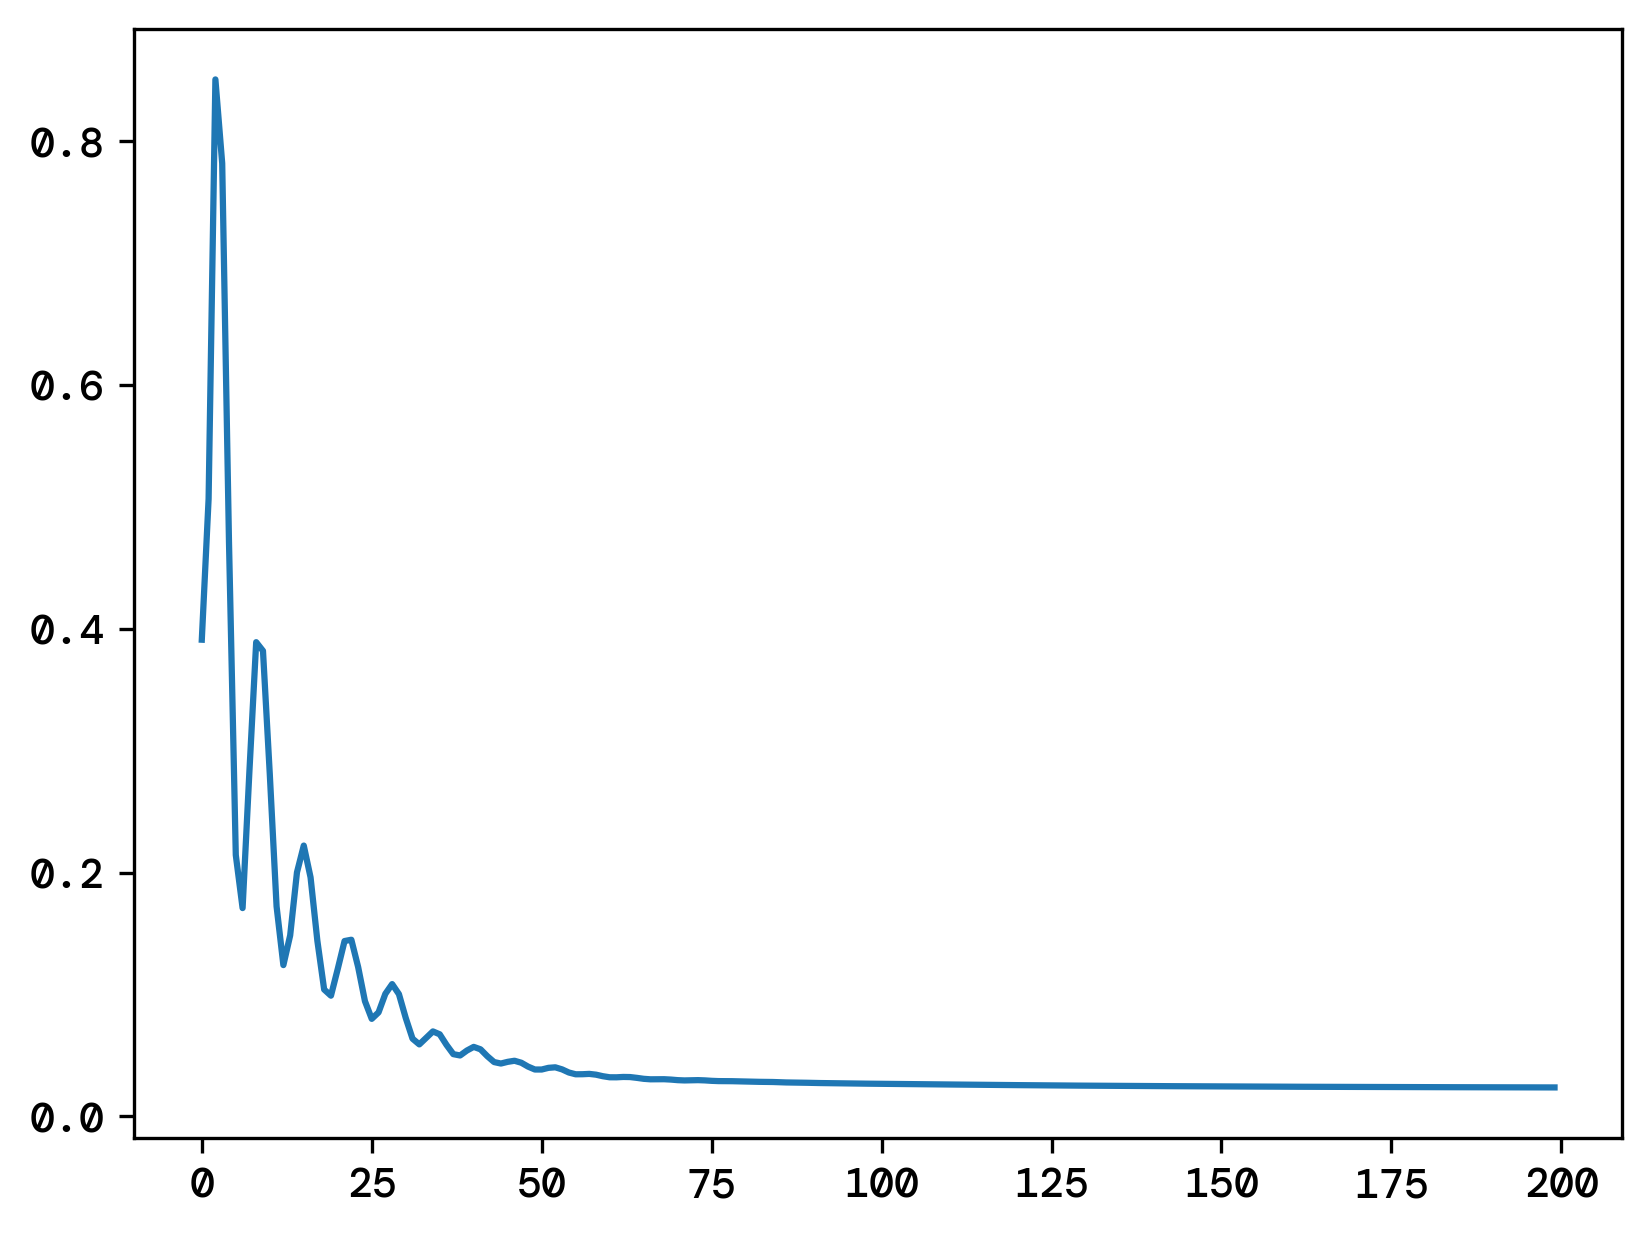

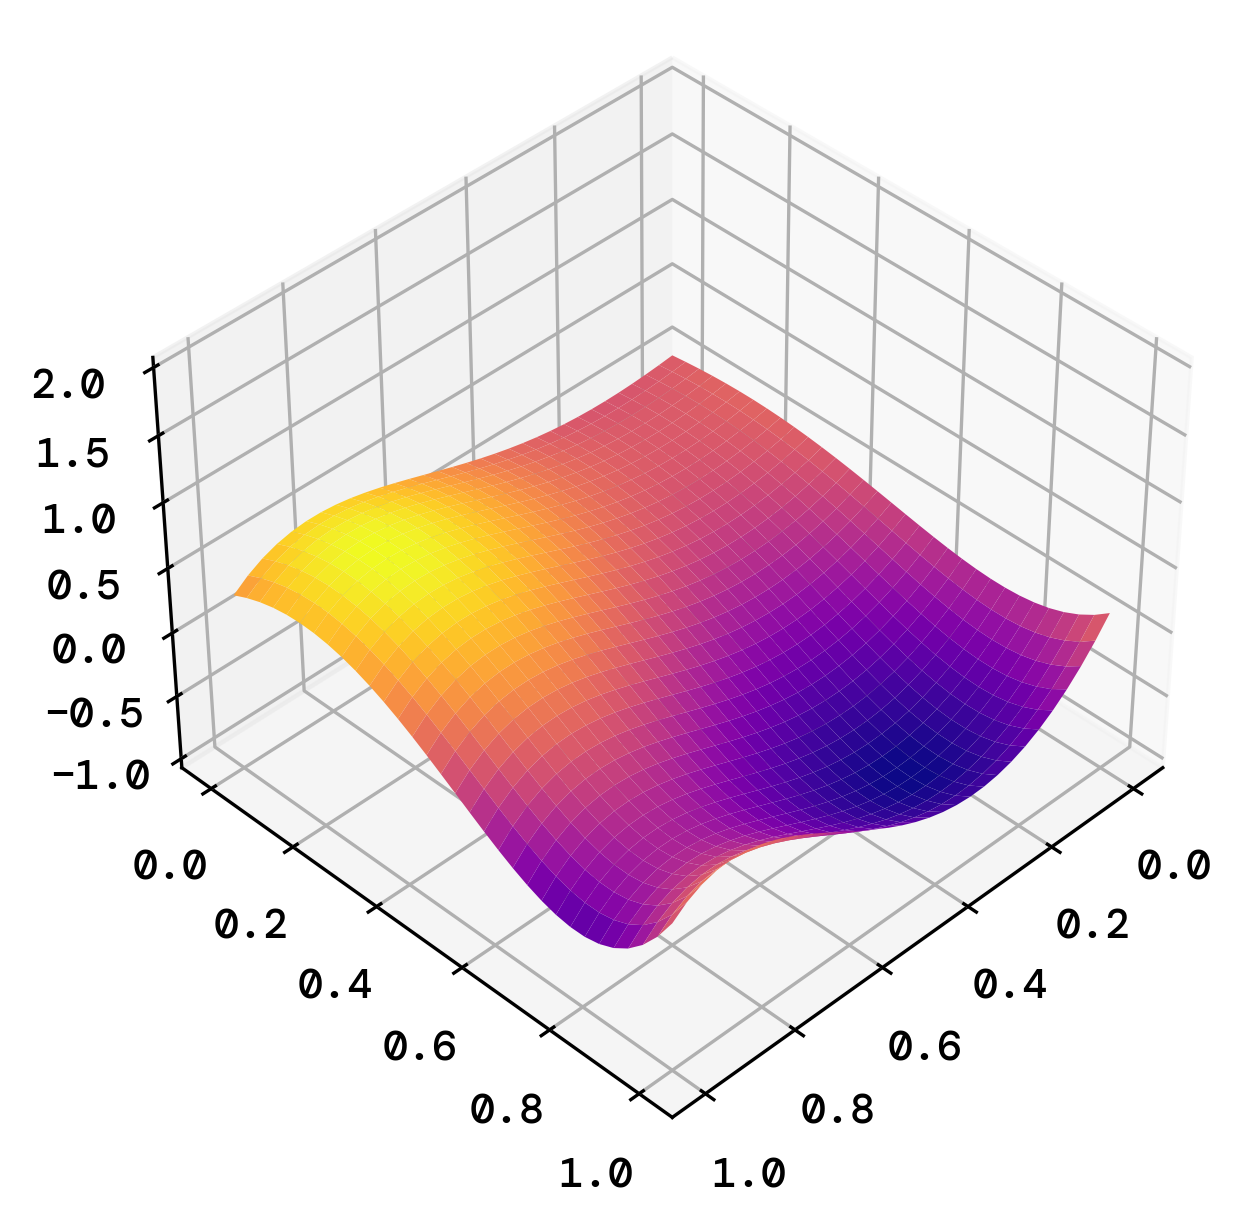

In [19]:
# plot predictions
poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)


print("X_train_poly shape: {}".format(X_train_poly.shape))

      
model = ada.NN.Model([[1,eye]], eta=0.1, epochs=200, tol=tol, alpha=0, gamma=0.5, optimizer="adam", loss=ada.MSE, metric=ada.MSE)

loss, params = model.fit(X_train_poly, y_train, X_test_poly, y_test)

y_pred = model.predict(scaler.transform(poly.transform(x)))


fig, ax = plt.subplots(1, 1)
ax.plot(loss)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, y_pred.reshape(32,32), cmap='plasma',
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)





In [20]:



model = ada.NN.Model([[10,relu],[15,sigmoid],[1,eye]], eta=0.1, epochs=200, tol=tol, alpha=0, optimizer="adam", loss=ada.MSE, metric=ada.MSE)

loss, params = model.fit(X_train, y_train, X_test, y_test)

y_pred = model.predict(scaler.transform(x))
# y_pred = model.predict(x)

print("loss: {}".format(loss[-1]))
fig, ax = plt.subplots(1, 1)
ax.plot(loss)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, y_pred.reshape(32,32), cmap='plasma',
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)

Training stopped after 199 epochs                                     

ValueError: X has 2 features, but StandardScaler is expecting 20 features as input.

In this analysis every model seemed to have converged with the same final MSE, give or take. However 
we see that some models allows us to use a wider range of learning rates. This is especially true for the models with momentum. These new optimizers and auto differentiation is a new tool in our toolbox that we can use to optimize our models.

## Compare with scikit-learn